In [1]:
import torch_geometric
import data_utils
import model
import torch
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
import networkx as nx
import time
import sklearn

In [28]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset_name = 'cora'
dataset = Planetoid('../dataset', dataset_name, transform=transform)
train_data, val_data, test_data = dataset[0]


def visualize_graph(G, color, pos=None):
    #plt.figure(figsize=(7,7))
    #plt.xticks([])
    #plt.yticks([])
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    if pos == None:
        pos=nx.spring_layout(G, seed=42)
    nx.draw_networkx(G,  with_labels=False,
                     node_color=color, cmap="Set2", node_size=2, arrows=False)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    #plt.xticks([])
    #plt.yticks([])
    #plt.xlim([-2,2])
    #plt.ylim([-2,2])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=20, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [92]:
import importlib
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
embedding_dim = 2

class VariationalGCN(torch.nn.Module):
    def __init__(self, num_features, embedding_dim, params):
        super().__init__()
        self.conv1 = GCNConv(num_features, 2*embedding_dim)
        self.mu_encoder = GCNConv(2*embedding_dim, embedding_dim)
        self.logstd_encoder = GCNConv(2*embedding_dim, embedding_dim)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)
    
class VariationalGAT(torch.nn.Module):
    def __init__(self, num_features, embedding_dim, params):
        super().__init__()
        self.conv1 = GATConv(num_features, 2*embedding_dim, heads=params["heads"], concat=False)
        self.mu_encoder = GATConv(2*embedding_dim, embedding_dim, heads=params["heads"], concat=False)
        self.logstd_encoder = GATConv(2*embedding_dim, embedding_dim, heads=params["heads"], concat=False)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)

class VariationalSAGE(torch.nn.Module):
    def __init__(self, num_features, embedding_dim, params):
        super().__init__()
        self.conv1 = SAGEConv(num_features, 2*embedding_dim, aggr=params["aggr"])
        self.mu_encoder = SAGEConv(2*embedding_dim, embedding_dim, aggr=params["aggr"])
        self.logstd_encoder = SAGEConv(2*embedding_dim, embedding_dim, aggr=params["aggr"])
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)

vae = torch_geometric.nn.models.VGAE(
    encoder=VariationalSAGE(dataset.num_features, embedding_dim, {"aggr": "mean"}),
    decoder=None
)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.05)  # Define optimizer.


def train(vae, data):
    vae.train()
    optimizer.zero_grad()  # Clear gradients.

    z = vae.encode(data.x, data.edge_index)

    recon_loss = vae.recon_loss(z, data.pos_edge_label_index)
    kld = vae.kl_loss()

    loss = recon_loss + 1/data.num_nodes * kld


    # OPTIMIZATION STEP
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.


    return float(loss), vae.decode(z, data.edge_index), z, float(kld), float(recon_loss)


@torch.no_grad()
def test(vae, data):
    vae.eval()
    z = vae.encode(data.x, data.edge_index)
    return vae.test(z, data.pos_edge_label_index, data.neg_edge_label_index), vae.recon_loss(z, data.pos_edge_label_index), vae.kl_loss()

losses = []

epochs = 1000
if False:
    for epoch in range(epochs):
        loss, A_recon, z, kld, recon_loss = train(vae,train_data)
        with torch.no_grad():
            #train_accuracy = torch.equal(torch.greater_equal(A_recon, 0.5).float(), train_data.edge_index)
            auc, ap, _, _ = test(val_data)
            losses.append([loss, kld, recon_loss, auc, ap])
            if epoch % 50 == 0 and embedding_dim == 2:
                visualize_embedding(z, color=train_data.y, epoch=epoch, loss=torch.tensor(loss))
                time.sleep(0.3)

In [175]:
import sklearn.model_selection
import pandas as pd
from tqdm import tqdm


gcn_params = {
    "embedding_dim": [2,3,4,5,10,20]
}
gat_params = {
    "embedding_dim": [2,3,4,5,10,20],
    "heads": [1,2,3,4,5]
}
sage_params = {
    "embedding_dim": [2,3,4,5,10,20],
    "aggr": ["mean", "min", "max"]
}
gcn_set = sklearn.model_selection.ParameterGrid(gcn_params)
gat_set = sklearn.model_selection.ParameterGrid(gat_params)
sage_set = sklearn.model_selection.ParameterGrid(sage_params)
total = [(VariationalGCN, s) for s in gcn_set] + [(VariationalGAT, s) for s in gat_set] + [(VariationalSAGE, s) for s in sage_set]

#results = pd.DataFrame(columns=["model", "step", "embedding_dim", "params", "train_kld", "train_recon_loss", "val_auc", "val_ap", "val_kld", "val_recon_loss"])
results = []
test_results = []
for (model_constructor, params) in tqdm(total):
    model = torch_geometric.nn.models.VGAE(encoder=model_constructor(dataset.num_features, params["embedding_dim"], params))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Define optimizer.
    epochs = 200
    for epoch in range(epochs):
        loss, A_recon, z, kld, recon_loss = train(model, train_data)
        if epoch % 10:
            with torch.no_grad():
                (auc, ap), val_recon_loss, val_kld = test(model, val_data)
                #visualize_embedding(z, color=train_data.y, epoch=epoch, loss=torch.tensor(loss))
                results.append({
                    "model": model_constructor.__name__,
                    "step": epoch,
                    "embedding_dim": params["embedding_dim"],
                    "params": str(params),
                    "train_kld": kld,
                    "train_recon_loss": recon_loss,
                    "val_auc": auc,
                    "val_ap": ap,
                    "val_kld": val_kld,
                    "val_recon_loss": val_recon_loss
                })
    escape = lambda x: x.replace("_", "")
    param_string = "_".join([f"{escape(key)}={item}" for key, item in params.items()])
    torch.save(model.state_dict(), f"saved_models/name={model_constructor.__name__}_{param_string}_epochs={epochs}")


100%|██████████| 54/54 [10:43<00:00, 11.91s/it]


/tmp/ipykernel_39496/2086181175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records["head"] = records["params"].apply(lambda x: eval(x)["heads"])
/tmp/ipykernel_39496/2086181175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records["head"] = records["params"].apply(lambda x: eval(x)["heads"])
/tmp/ipykernel_39496/2086181175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

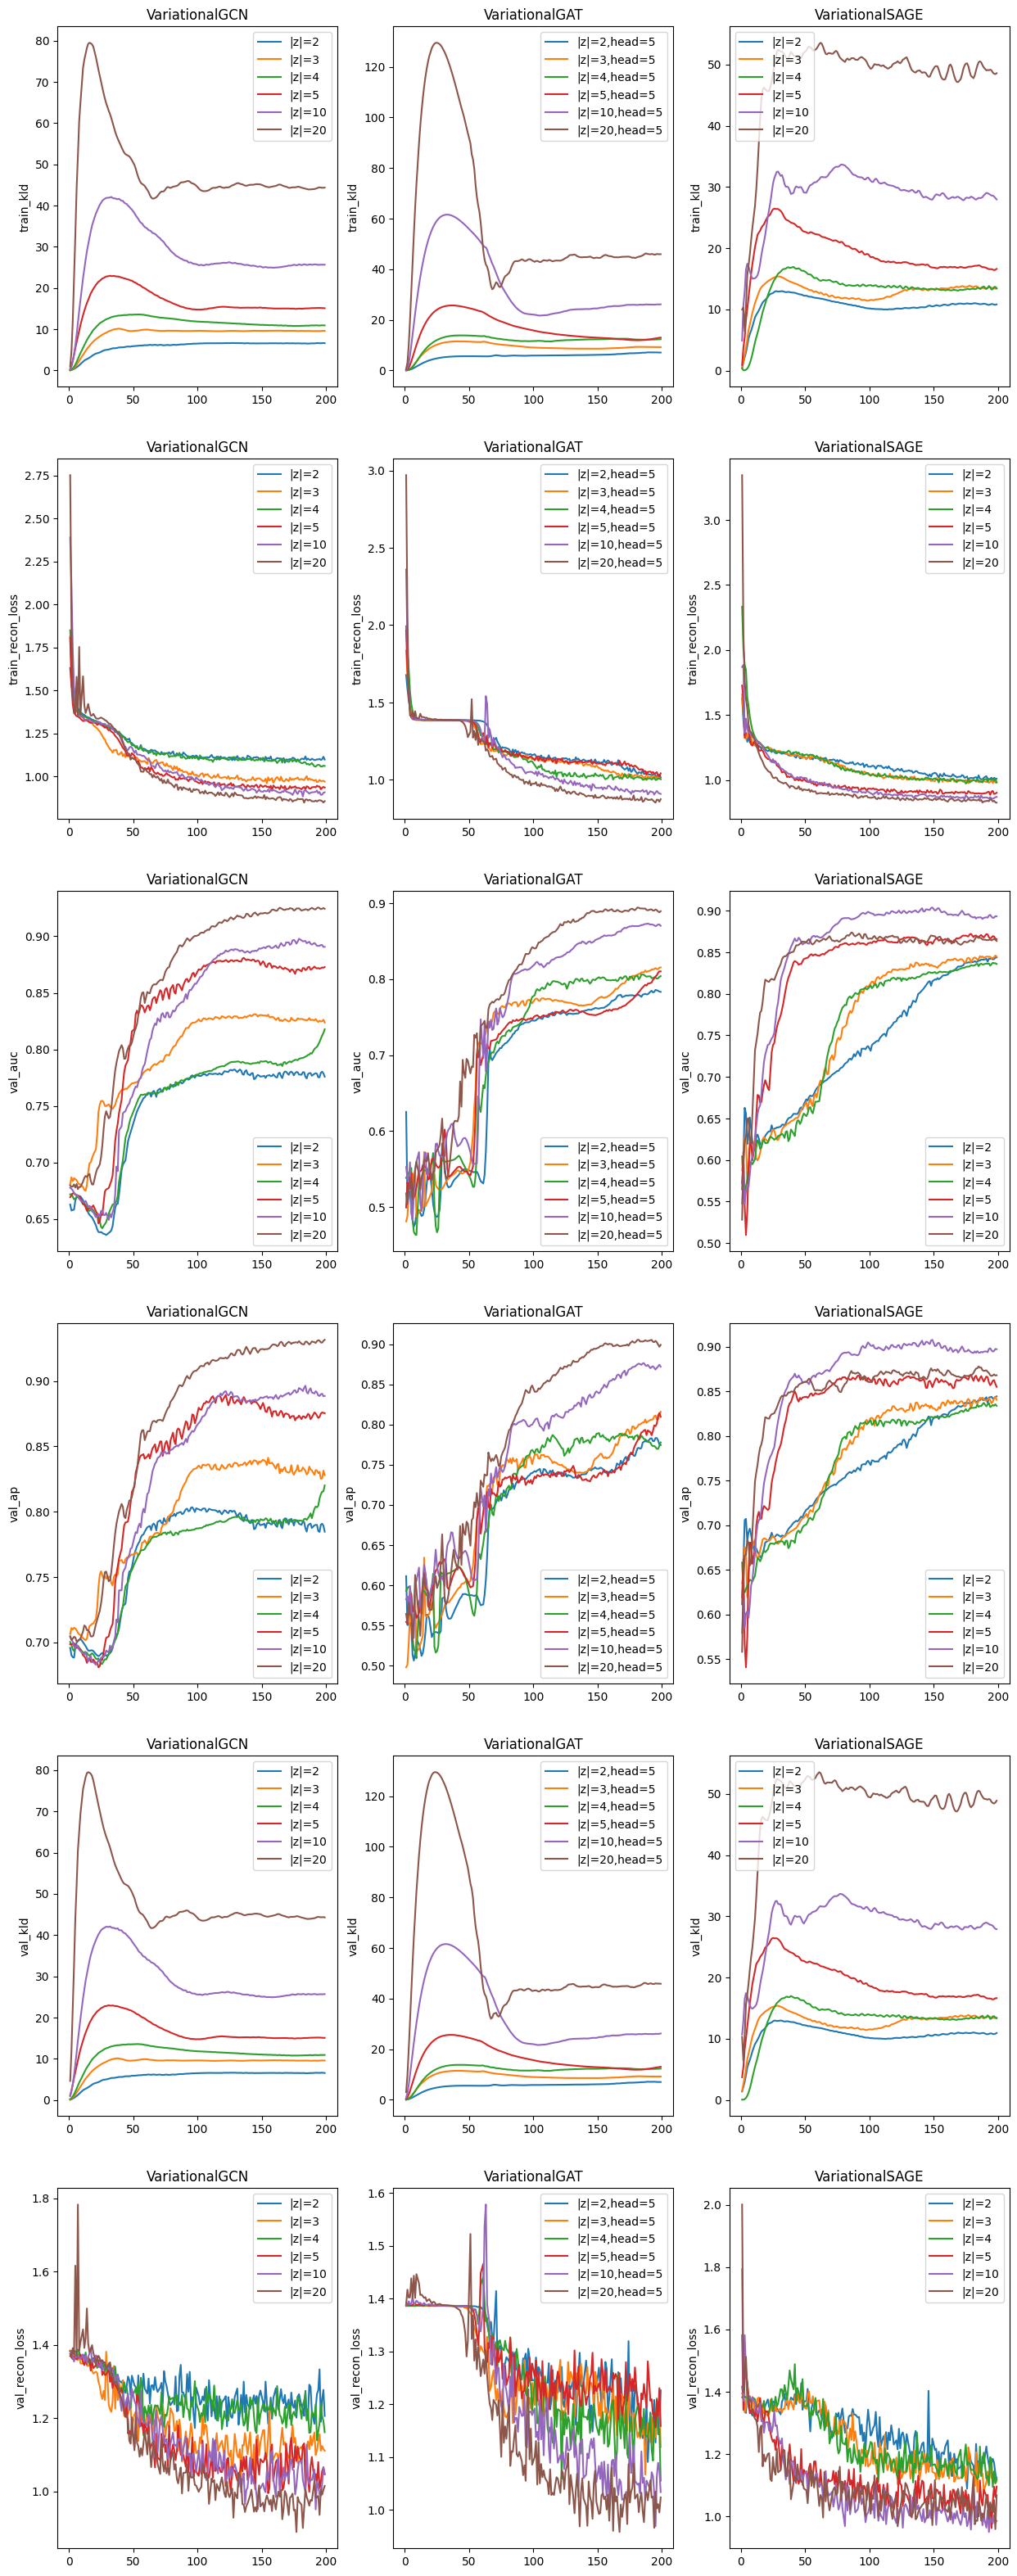

In [176]:
df = pd.DataFrame.from_dict(results)
metrics = ["train_kld", "train_recon_loss", "val_auc", "val_ap", "val_kld", "val_recon_loss"]
fig, axs = plt.subplots(len(metrics),3, figsize=(15,40))
for row_idx, metric in enumerate(metrics):
    for idx, model_type in enumerate(["VariationalGCN", "VariationalGAT", "VariationalSAGE"]):
        if model_type == "VariationalGCN":
            for embedding_dim in [2,3,4,5, 10, 20]:
                records = df.loc[(df["embedding_dim"] == embedding_dim) & (df["model"] == model_type)]
                axs[row_idx,idx].plot(records["step"], records[metric], label=f"|z|={embedding_dim}")
        if model_type == "VariationalGAT":
            for embedding_dim in [2,3,4,5, 10, 20]:
                records = df.loc[(df["embedding_dim"] == embedding_dim) & (df["model"] == model_type)]
                records["head"] = records["params"].apply(lambda x: eval(x)["heads"])
                r = records[records["head"] == 5]
                axs[row_idx,idx].plot(r["step"], r[metric], label=f"|z|={embedding_dim},head={5}")
        if model_type == "VariationalSAGE":
            for embedding_dim in [2,3,4,5, 10, 20]:
                records = df.loc[(df["embedding_dim"] == embedding_dim) & (df["model"] == model_type)]
                records["aggr"] = records["params"].apply(lambda x: eval(x)["aggr"])
                r = records[records["aggr"] == "max"]
                axs[row_idx,idx].plot(r["step"], r[metric], label=f"|z|={embedding_dim}")
        axs[row_idx,idx].legend()
        axs[row_idx,idx].set_title(model_type)
        axs[row_idx,idx].set_ylabel(metric)

In [89]:
df["params"]

0                       {'embedding_dim': 2}
1                       {'embedding_dim': 2}
2                       {'embedding_dim': 2}
3                       {'embedding_dim': 2}
4                       {'embedding_dim': 2}
                        ...                 
4855    {'aggr': 'max', 'embedding_dim': 20}
4856    {'aggr': 'max', 'embedding_dim': 20}
4857    {'aggr': 'max', 'embedding_dim': 20}
4858    {'aggr': 'max', 'embedding_dim': 20}
4859    {'aggr': 'max', 'embedding_dim': 20}
Name: params, Length: 4860, dtype: object

In [177]:
import os
test_results = []
for model_path in os.listdir("saved_models"):
    model_constructor = eval(model_path.split("_")[0].split("=")[1])
    embedding_dim = int([p.split("=") for p in model_path.split("_") if p.split("=")[0] == "embeddingdim"][0][1])
    heads = int(model_path.split("heads=")[1].split("_")[0]) if "heads" in model_path else None
    aggr = model_path.split("aggr=")[1].split("_")[0].split("-")[0] if "aggr" in model_path else None
    model = torch_geometric.nn.models.VGAE(model_constructor(dataset.num_features, embedding_dim, {
        "heads": heads,
        "aggr": aggr
    }))
    model_path = os.path.join("saved_models", model_path)
    
    model.load_state_dict(torch.load(model_path, weights_only=True))
    with torch.no_grad():
        (auc, ap), recon, kld = test(model, test_data)
        test_results.append({
            "model_name": model_constructor.__name__,
            "auc": auc,
            "ap": ap,
            "recon": recon,
            "kld": kld,
            "heads": heads,
            "aggr": aggr,
            "parameters": sum(p.numel() for p in model.parameters()),
        })

Text(0, 0.5, 'Test AP')

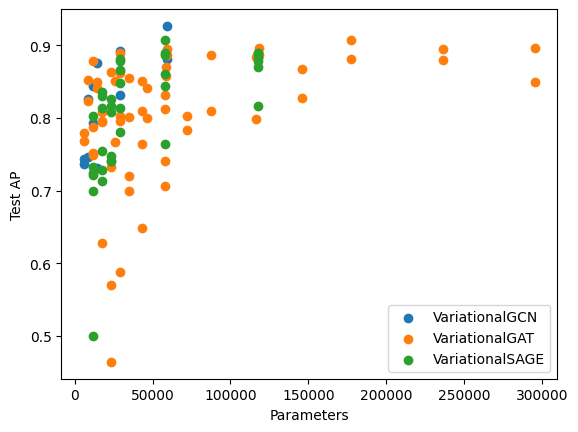

In [178]:
test_df = pd.DataFrame.from_dict(test_results)
colormap = {
    "VariationalGCN": "green",
    "VariationalGAT": "red",
    "VariationalSAGE": "blue",
}
for model_type in colormap.keys():
    r = test_df[test_df["model_name"] == model_type]
    plt.scatter(r["parameters"], r["ap"], label=model_type)
plt.xlabel("Parameters")
plt.legend()
plt.ylabel("Test AP")

Text(0, 0.5, 'Average Precision')

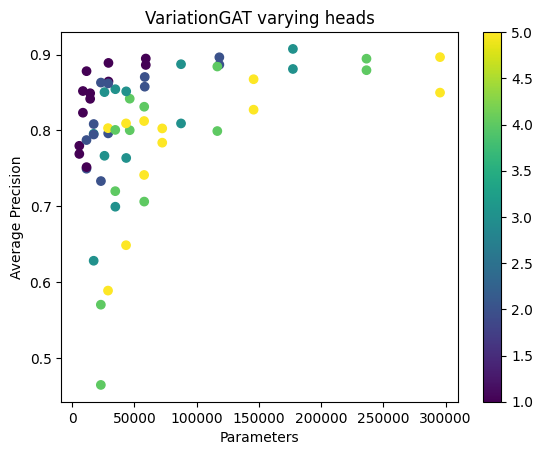

In [179]:
test_gats = test_df[test_df["model_name"] == "VariationalGAT"]
plt.scatter(test_gats["parameters"], test_gats["ap"], c=test_gats["heads"])
plt.colorbar()
plt.xlabel("Parameters")
plt.title("VariationGAT varying heads")
plt.ylabel("Average Precision")

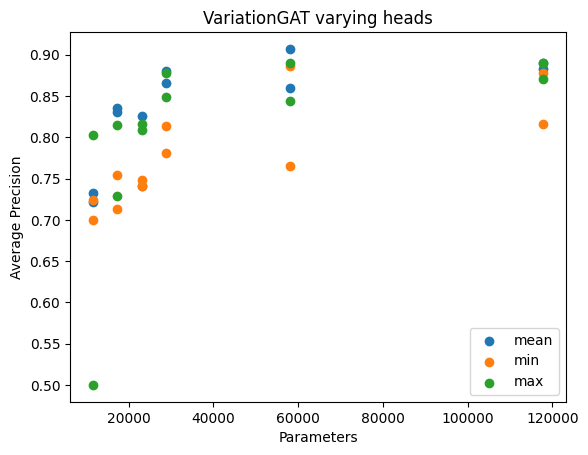

In [181]:
for aggr in sage_params["aggr"]:
    test_gats = test_df[(test_df["model_name"] == "VariationalSAGE") & (test_df["aggr"] == aggr)]
    plt.scatter(test_gats["parameters"], test_gats["ap"], label=aggr)
    plt.legend()
    plt.xlabel("Parameters")
    plt.title("VariationGAT varying heads")
    plt.ylabel("Average Precision")

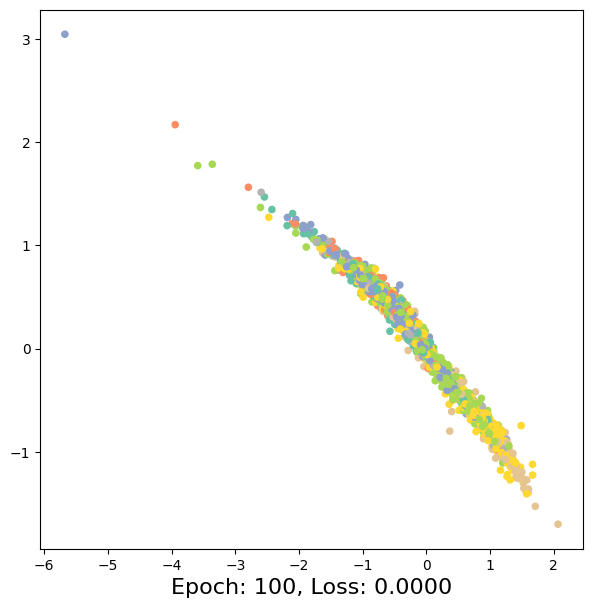

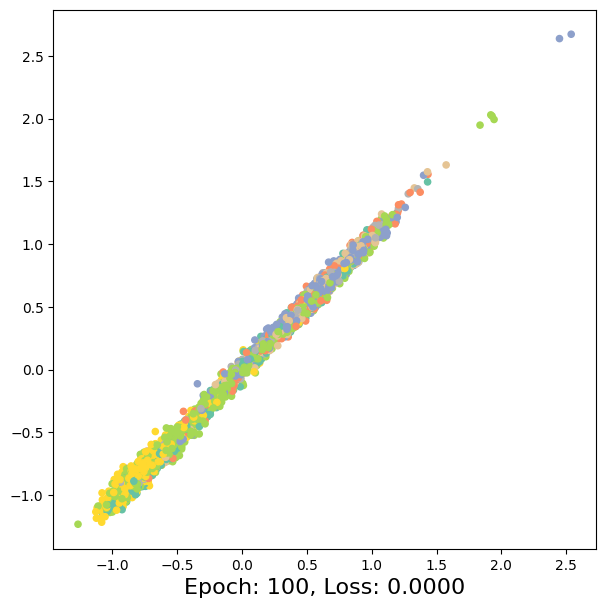

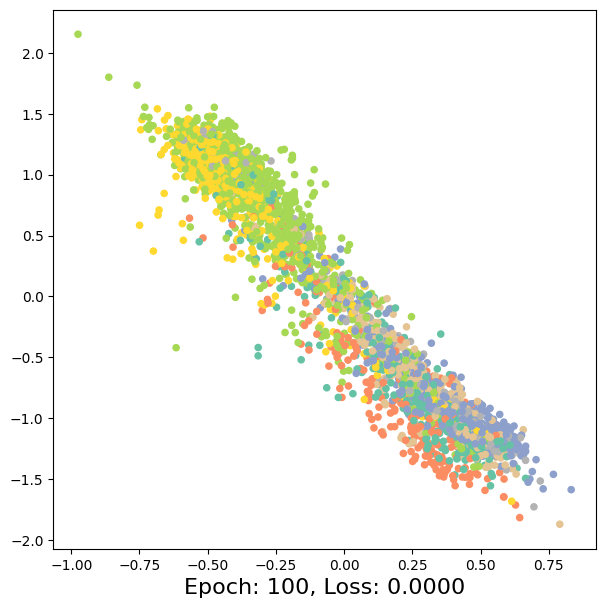

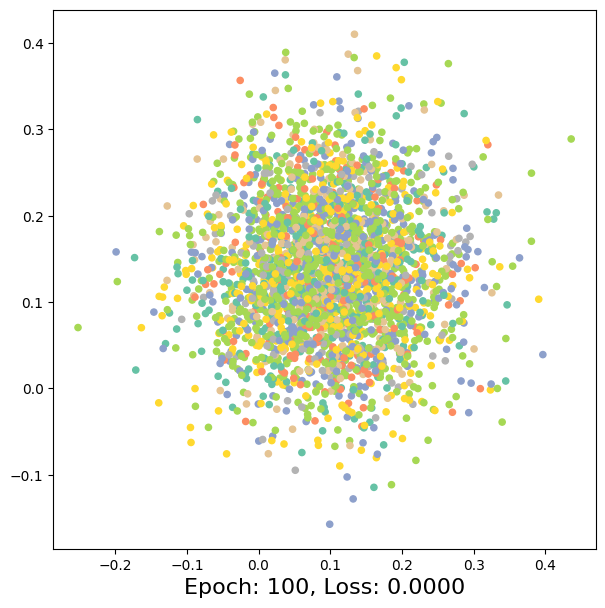

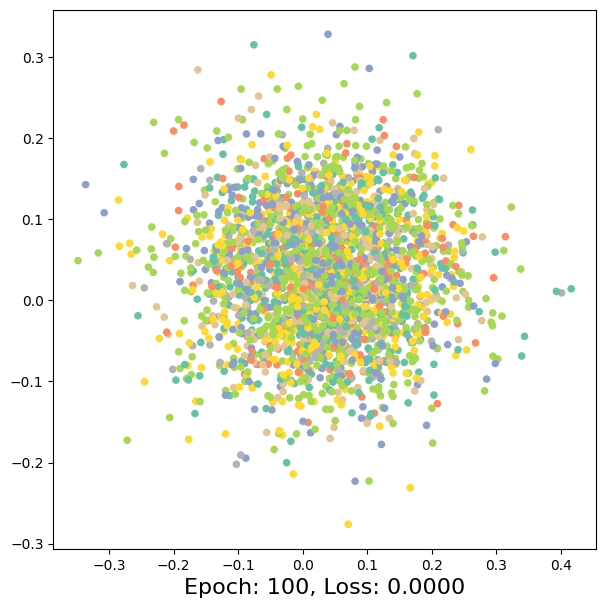

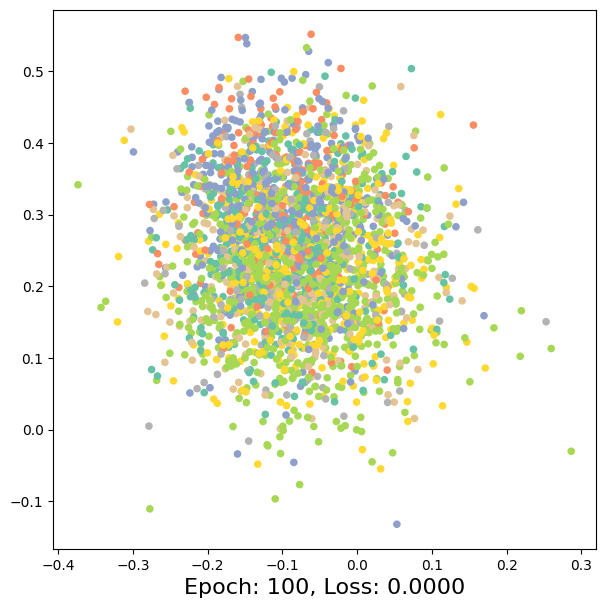

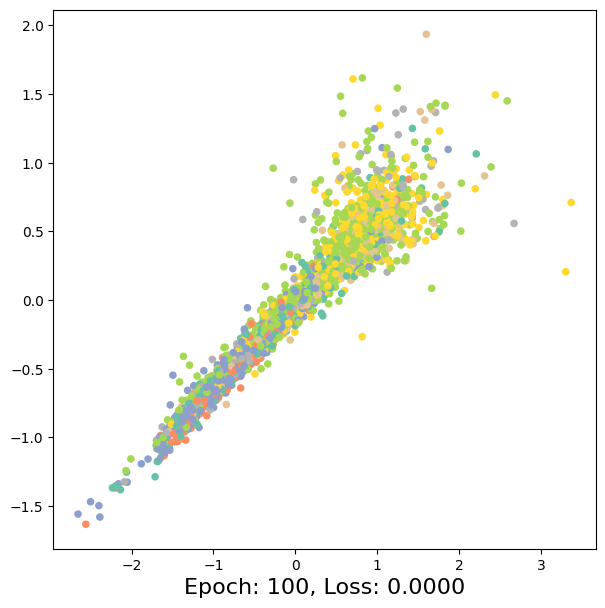

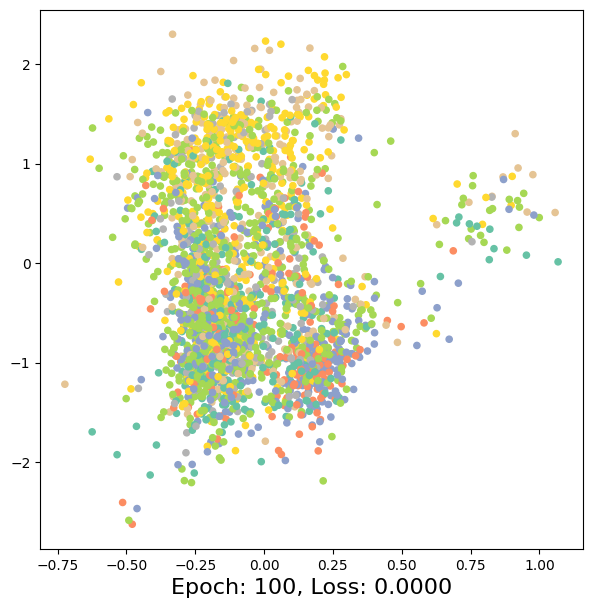

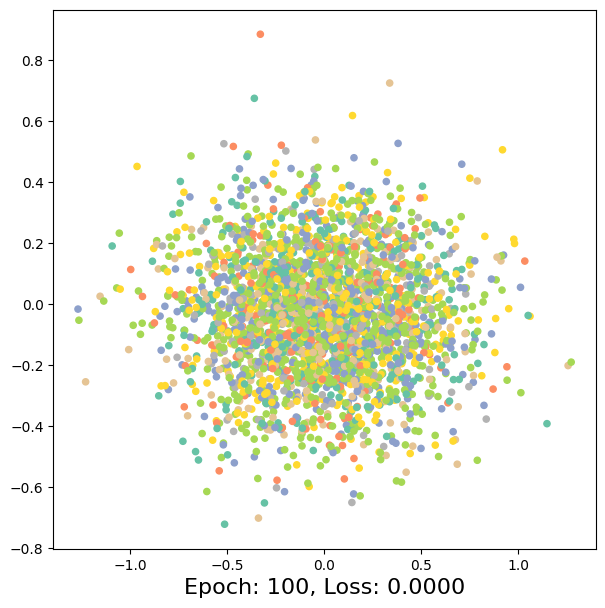

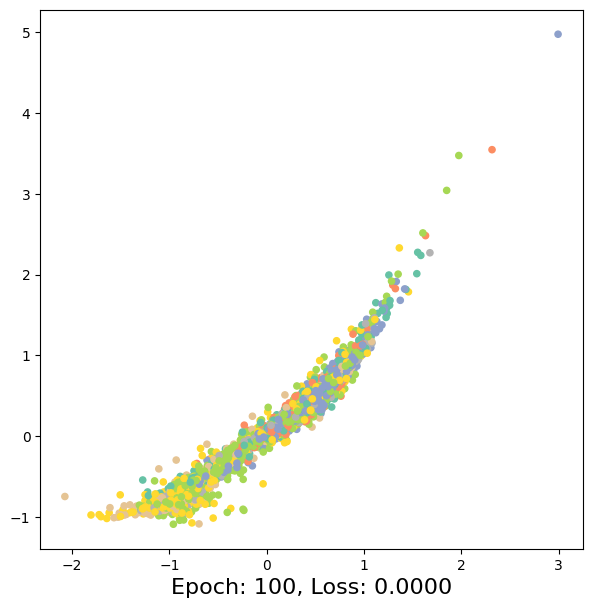

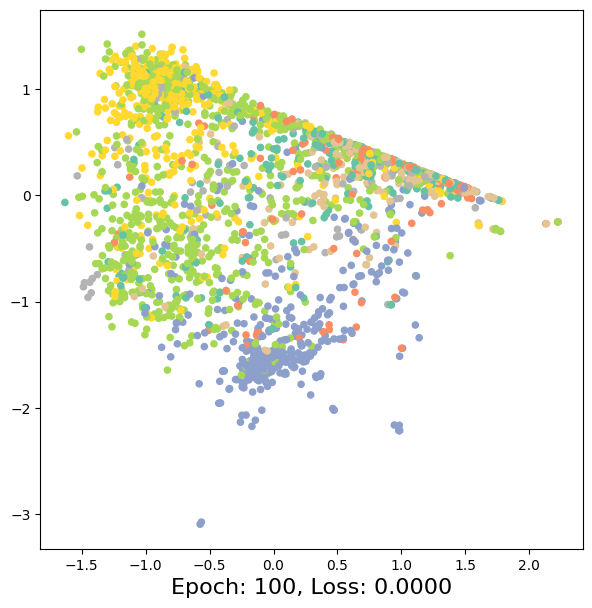

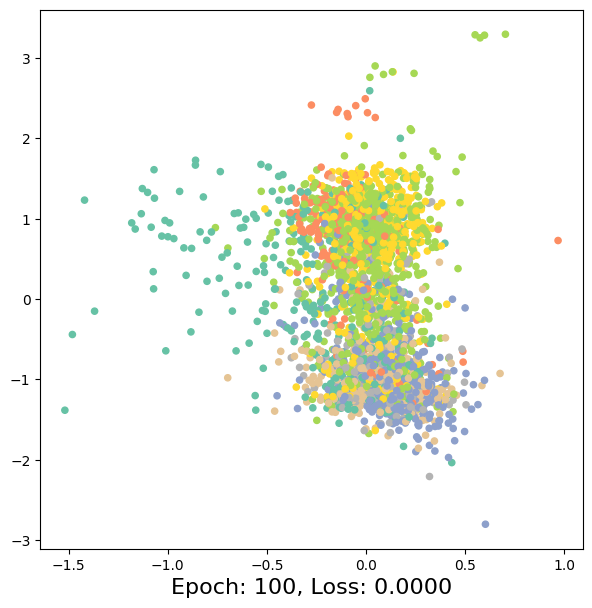

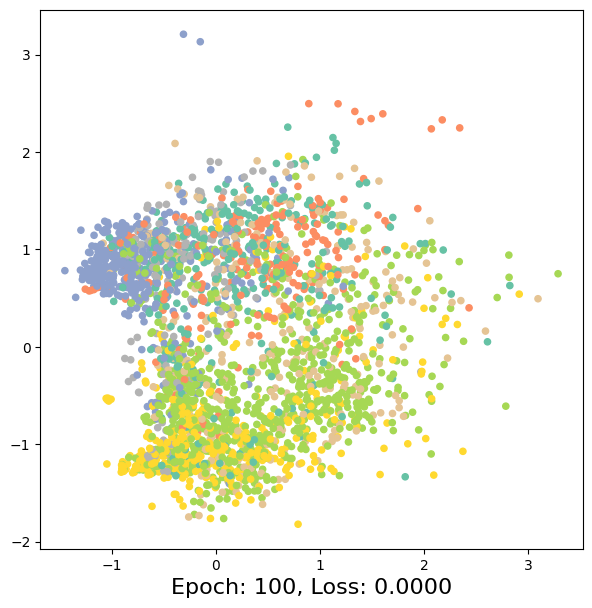

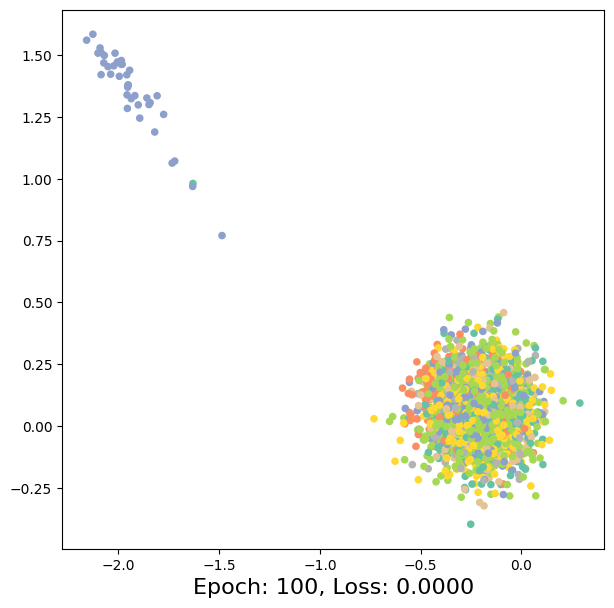

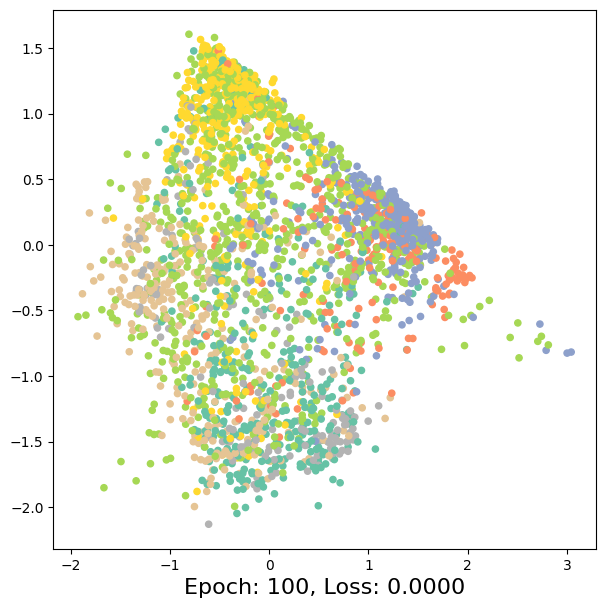

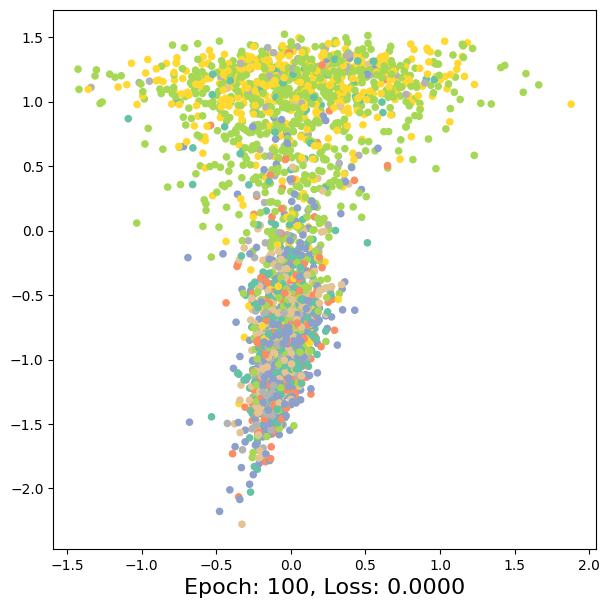

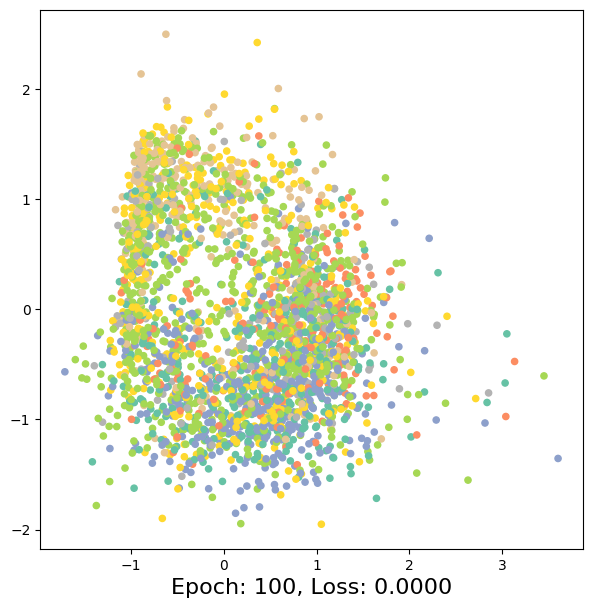

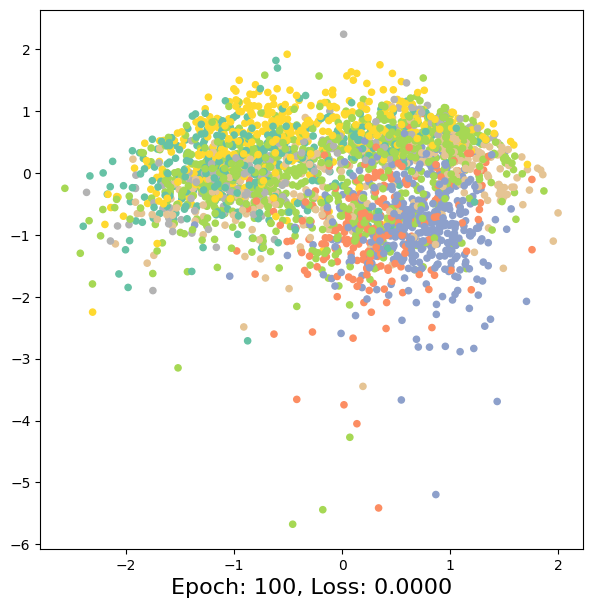

In [182]:

import os
test_results = []
for model_path in os.listdir("saved_models"):
    model_constructor = eval(model_path.split("_")[0].split("=")[1])
    embedding_dim = int([p.split("=") for p in model_path.split("_") if p.split("=")[0] == "embeddingdim"][0][1])
    if embedding_dim > 2:
        continue
    heads = int(model_path.split("heads=")[1].split("_")[0]) if "heads" in model_path else None
    aggr = model_path.split("aggr=")[1].split("_")[0].split("-")[0] if "aggr" in model_path else None
    model = torch_geometric.nn.models.VGAE(model_constructor(dataset.num_features, embedding_dim, {
        "heads": heads,
        "aggr": aggr
    }))
    model_path = os.path.join("saved_models", model_path)
    
    model.load_state_dict(torch.load(model_path, weights_only=True))
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
        A = model.decode(z, test_data.edge_index)
        visualize_embedding(z, color=test_data.y, epoch=100, loss=torch.tensor(0))
